Persis Trial-5 tapi datanya dari CSV

#### Import Library

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

import random

#### N_step dan Nama Model Plot

In [14]:
# Konfigurasi Waktu dan unit_steps
n_steps = 7
modelLastDate = '27 Mar'
plotDate = '28-3 Apr'
modelName = 'T7_n'+str(n_steps)+'_' + modelLastDate + '.h5'
plotName = 'T7_n'+str(n_steps)+'_'+plotDate+'.jpg'
lossPlot = 'T7_loss_'+modelLastDate+'.jpg'

test_start = '2024-03-28'
test_end = '2024-04-03'

model = load_model('model/'+modelName)
print(model.summary(expand_nested=True, show_trainable=True))


Model: "sequential_175"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm_525 (LSTM)             (None, 7, 128)            66560     Y          
                                                                            
 dropout_350 (Dropout)       (None, 7, 128)            0         Y          
                                                                            
 lstm_526 (LSTM)             (None, 7, 64)             49408     Y          
                                                                            
 dropout_351 (Dropout)       (None, 7, 64)             0         Y          
                                                                            
 lstm_527 (LSTM)             (None, 16)                5184      Y          
                                                                            
 dense_175 (Dense)           (None, 1)              

#### Getting Data

In [62]:
# Read data from CSV file
csv_file_path = 'data/real-1mei.csv'
data = pd.read_csv(csv_file_path, sep=';')

# Convert date strings to datetime objects
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.date

test_start_date = datetime.strptime(test_start, '%Y-%m-%d').date()
test_end_date = datetime.strptime(test_end, '%Y-%m-%d').date()

train_data = data[data['date'] < test_start_date]
lenTrain = len(train_data)
test_data = data[lenTrain:lenTrain+15]
test_data


,date,real
87,2024-03-28,12150
88,2024-03-29,12630
89,2024-03-30,260
90,2024-03-31,220
91,2024-04-01,8470
92,2024-04-02,9880
93,2024-04-03,13070
94,2024-04-04,10280
95,2024-04-05,10660
96,2024-04-06,250


#### Data Splitting

In [63]:
train_energies = train_data['real'].values.reshape(-1, 1)
test_energies = test_data['real'].values.reshape(-1, 1)

#### Normalize the data

In [64]:
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_energies)
test_data_normalized = scaler.transform(test_energies)

In [65]:
# Prepare the data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
X_train, y_train = prepare_data(train_data_normalized, n_steps)
X_test, y_test = prepare_data(test_data_normalized, n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#### Load Model

In [67]:
model = load_model("model/" + modelName)
print(model.summary())

Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_525 (LSTM)             (None, 7, 128)            66560     
                                                                 
 dropout_350 (Dropout)       (None, 7, 128)            0         
                                                                 
 lstm_526 (LSTM)             (None, 7, 64)             49408     
                                                                 
 dropout_351 (Dropout)       (None, 7, 64)             0         
                                                                 
 lstm_527 (LSTM)             (None, 16)                5184      
                                                                 
 dense_175 (Dense)           (None, 1)                 17        
                                                                 
Total params: 121169 (473.32 KB)
Trainable params: 1

#### Evaluate the Model

In [68]:
test_energies = test_energies[:-8]
date_test = test_data['date'][:-8]

#### Make Prediction

In [69]:
predictions = []
current_batch = train_data_normalized[-n_steps:].reshape((1, n_steps, 1))

for _ in range(len(test_energies)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

predictions

[array([0.8601729], dtype=float32),
 array([0.94226813], dtype=float32),
 array([-0.036298], dtype=float32),
 array([0.0129778], dtype=float32),
 array([0.663113], dtype=float32),
 array([0.7731284], dtype=float32),
 array([0.88346153], dtype=float32)]

In [70]:
predictions = scaler.inverse_transform(predictions)
predictions = np.round(predictions,2)
for i in range (len(predictions)):
    # if predictions[i] < 0 :
    #     predictions[i] =+ 240.00
    if predictions[i] < 2000:
        predictions[i] = 250 #atau random.randint(250, 300)

# Define a lambda function to format numbers with ',' as the decimal separator
custom_format = lambda x: f'{x:.8f}'.replace('.', ',')

# Convert the array to a string with ',' as the decimal separator
formatted_predictions = '\n'.join([','.join(map(lambda x: f'{x:.8f}'.replace('.', ','), row)) for row in predictions])

# Save the formatted predictions to a text file
with open('predictions.txt', 'w') as file:
    file.write(formatted_predictions)
predictions

array([[11598.69],
       [12685.63],
       [  250.  ],
       [  250.  ],
       [ 8989.62],
       [10446.22],
       [11907.03]])

#### Calculate Error

In [71]:
def calculate_mape(actual, predicted, epsilon=1e-10):
    mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100
    return mape
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

mape = calculate_mape(test_energies, predictions)
mae = calculate_mae(test_energies, predictions)
rmse = calculate_rmse(test_energies, predictions)

print(test_energies.flatten().tolist())
print(np.array(predictions).flatten().tolist())
print("--------------------")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

[12150, 12630, 260, 220, 8470, 9880, 13070]
[11598.69, 12685.63, 250.0, 250.0, 8989.62, 10446.22, 11907.03]
--------------------
MAE: 413.68
MAPE: 6.17%
RMSE: 567.09


### Plotting Result

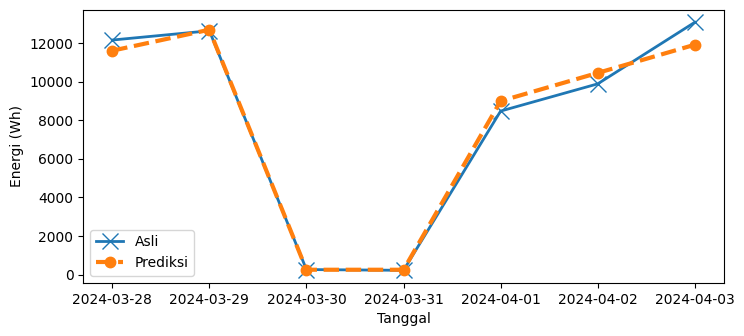

In [72]:
x,y = [21,9]

# Plot the results
plt.figure(figsize=(x/2.54, y/2.54))
plt.plot(date_test, test_energies.flatten(), label='Asli', linewidth=2, marker='x', markersize=12)
plt.plot(date_test, predictions, label='Prediksi', linewidth=3, linestyle='--', marker='.', markersize=15)
# plt.title('Realita vs Prediksi Energi Harian '+plotDate)
plt.xlabel('Tanggal')
plt.ylabel('Energi (Wh)')
plt.legend()
plt.savefig('plot/'+plotName, bbox_inches='tight')
plt.show()

In [73]:
# plt.figure(figsize=(12.8, 5.4))
# plt.plot(dates, energies, label='Asli', linewidth=1, marker='x', markersize=12)
# plt.plot(newDateTest, predictions, label='Prediksi', linewidth=2, linestyle='--', marker='.', markersize=14)
# plt.title('Realita vs Prediksi Energi Harian')
# plt.xlabel('Tanggal')
# plt.ylabel('Energi (Wh)')
# plt.legend()
# plt.show()